In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import svm, datasets
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

%matplotlib inline 
import matplotlib.pyplot as plt
from inspect import signature

import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns; sns.set_theme()

In [2]:
import pickle
import shap
import eli5
from eli5.sklearn.permutation_importance import PermutationImportance
from pdpbox import pdp
from matplotlib.cm import PuOr
from pycebox.ice import ice, ice_plot
from treeinterpreter import treeinterpreter as ti

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [3]:
import utils
from utils import plot_features_importance, prepare_interpretable_contribution, plot_observation_contribution
from utils import plot_single_feature, plot_scores
import plotly.offline as offline
import plotly.graph_objs as go

In [64]:
from utils import compute_y_pred_from_query

ImportError: cannot import name 'compute_y_pred_from_query' from 'utils' (/Users/alexei/lead-scoring-alessio-marieme/notebook/utils/__init__.py)

In [4]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import skrules
from skrules import SkopeRules

In [5]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC

In [6]:
from lead_scoring_marieme_alessio.config import config as cf
from lead_scoring_marieme_alessio.domain.pipeline_transformer import pipeline_transformer
from lead_scoring_marieme_alessio.infrastructure.clean_data_transformer import CleanDataTransformer

# 1. Construct a predict model  <a name="part1"></a>

In [7]:
full_pipeline = pipeline_transformer()

In [8]:
path = "../data/data.csv"
clean_data= CleanDataTransformer(path)
df_test = clean_data.load_cleaned_data()
y = df_test['TARGET']
X = df_test.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

In [9]:
X_train = full_pipeline.fit_transform(X_train, y_train)

In [10]:
X_test = full_pipeline.transform(X_test)

In [11]:
ohe_categories = full_pipeline.__dict__['transformer_list'][0][1].__dict__['steps'][3][1].__dict__['categories_']
new_ohe_categories = [ f"{col}__{val}" for col, vals in zip(cf.CAT_FEAT, ohe_categories) for val in vals ]
new_ohe_categories = [ n.replace(" ", "_") for n in new_ohe_categories ] 
new_ohe_categories = [ n.replace("'", "_") for n in new_ohe_categories ] 
ALL_FEAT = new_ohe_categories + cf.NUM_FEAT + cf.CAT_FEAT_ORD
X_train_dummified = pd.DataFrame(data=X_train, columns=ALL_FEAT)
X_test_dummified = pd.DataFrame(data=X_test, columns=ALL_FEAT)

In [12]:
model = RandomForestClassifier(
    criterion='gini',
    min_samples_split=3,
    n_estimators=100, 
    random_state=42)
model.fit(X_train_dummified, y_train)

RandomForestClassifier(min_samples_split=3, random_state=42)

In [13]:
y_score = model.predict_proba(X_test_dummified)[:, 1]

In [14]:
precision_recall_curve(y_test, y_score)

(array([0.41272431, 0.46761258, 0.46876933, 0.47080745, 0.47790404,
        0.48965071, 0.49028497, 0.49187784, 0.49219766, 0.49315961,
        0.4934811 , 0.49477124, 0.49509483, 0.51114112, 0.51183232,
        0.51217862, 0.51252539, 0.51391718, 0.5142663 , 0.51566757,
        0.51601909, 0.51956074, 0.51991758, 0.52063274, 0.52099105,
        0.52134986, 0.53385049, 0.53498233, 0.53687943, 0.53955809,
        0.54032834, 0.54187545, 0.54226361, 0.54265233, 0.54304161,
        0.54343144, 0.5442128 , 0.54538905, 0.55303584, 0.5534407 ,
        0.55384615, 0.5542522 , 0.55465884, 0.55506608, 0.55547392,
        0.55875831, 0.5591716 , 0.55958549, 0.56083086, 0.56124722,
        0.56208178, 0.5625    , 0.56842105, 0.56884876, 0.56927711,
        0.57403189, 0.57446809, 0.57798165, 0.57842387, 0.58019954,
        0.58064516, 0.58109147, 0.58153846, 0.58198614, 0.58243451,
        0.58288358, 0.58832685, 0.58878505, 0.58924396, 0.58970359,
        0.59016393, 0.59340659, 0.59387274, 0.59

In [15]:
average_precision = average_precision_score(y_test, y_score)
average_precision

0.9756600519569605

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

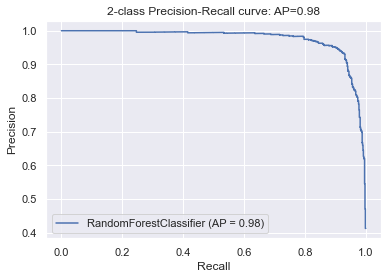

In [16]:
disp = plot_precision_recall_curve(model, X_test_dummified, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

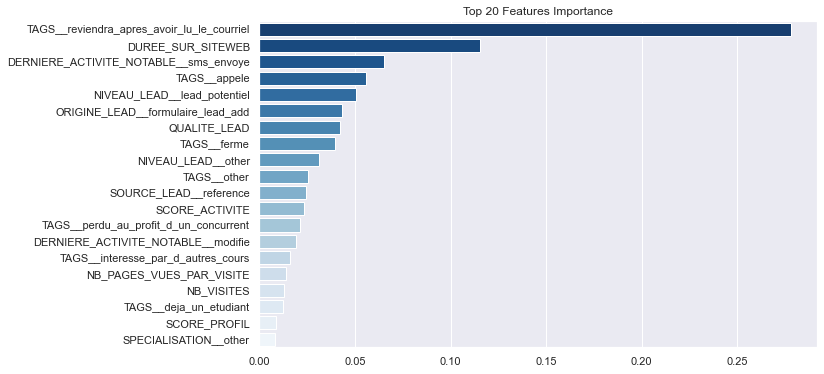

In [257]:
plot_features_importance(X_train_dummified , model.feature_importances_, 20)

## Save the model and data  <a name="part1.f"></a>

In [258]:
data_model_dict = {
    'X_train': X_train_dummified,
    'X_test': X_test_dummified, 
    'y_train': y_train,
    'y_test': y_test,
    'model': model
}

In [259]:
with open('data_model_rf.pickle', 'wb') as handle:
    pickle.dump(data_model_dict, handle)

# 2. Prediction sensibility analysis - visualisation <a name="part2"></a>

## Import model and data <a name="part2.a"></a>

In [260]:
import pickle

with open('data_model_rf.pickle', 'rb') as handle:
    data_model_dict = pickle.load(handle)

X_train, X_test, y_train, y_test, model = data_model_dict.values()
f_predict = lambda x: model.predict_proba(x)[:, 1]

In [261]:
f_predict(X_test.sample(10, random_state=42))

array([0.89392958, 0.22121973, 0.06841659, 0.12423157, 0.18419757,
       0.94985389, 0.06505908, 0.69428451, 0.85670509, 0.08981734])

## Permutation importances <a name="part2.b"></a>

In [262]:
PermImp = PermutationImportance(model, n_iter=20, random_state=42, cv='prefit', refit=False)

In [263]:
PermImp.fit(X_test_dummified, y_test)

PermutationImportance(estimator=RandomForestClassifier(max_depth=10,
                                                       random_state=42),
                      n_iter=20, random_state=42, refit=False)

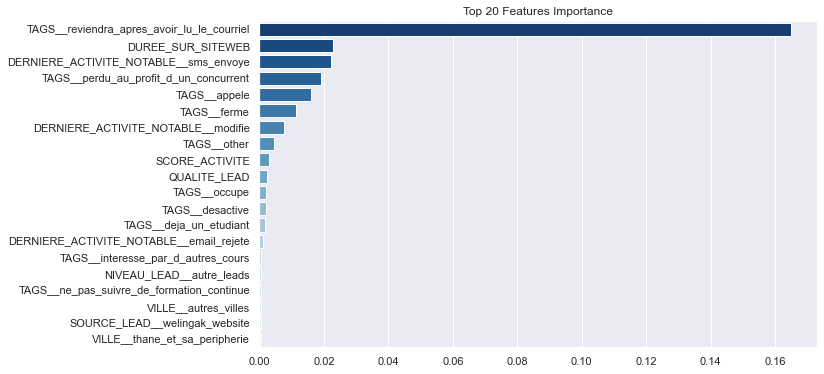

In [264]:
plot_features_importance(X_test_dummified, PermImp.feature_importances_, n_feat=20)

## Partial Dependance Plots (PDP curves) <a name="part2.c"></a>

In [265]:
def pdp_curve(variable) :

    pdp_goals = pdp.pdp_isolate(model=model,
                                dataset=X_test,
                                model_features=X_test.columns,
                                feature=variable,
                                num_grid_points=20,
                                grid_type='percentile', #possible values: 'equal' or 'percentile'
    )

    pdp.pdp_plot(pdp_goals, variable, center=True) # center arg center plots and compare each value to the first one
    plt.show()

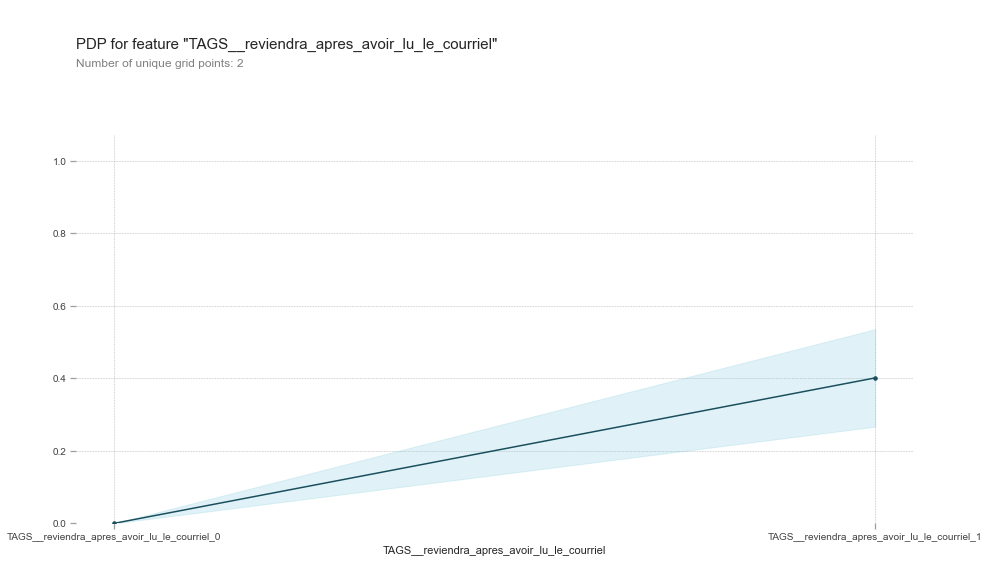

In [266]:
variable = 'TAGS__reviendra_apres_avoir_lu_le_courriel' 
pdp_curve(variable)

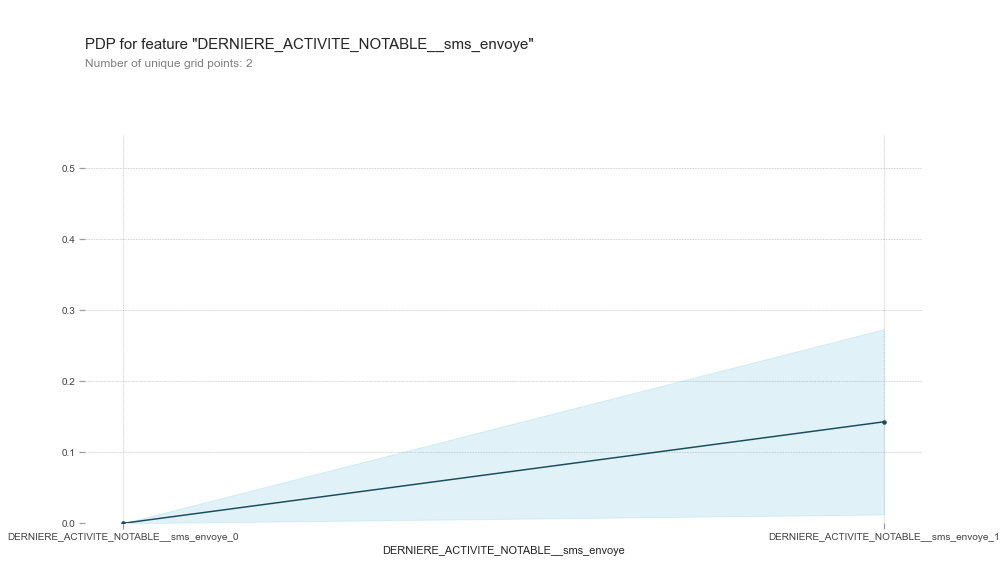

In [267]:
variable = 'DERNIERE_ACTIVITE_NOTABLE__sms_envoye' 
pdp_curve(variable)

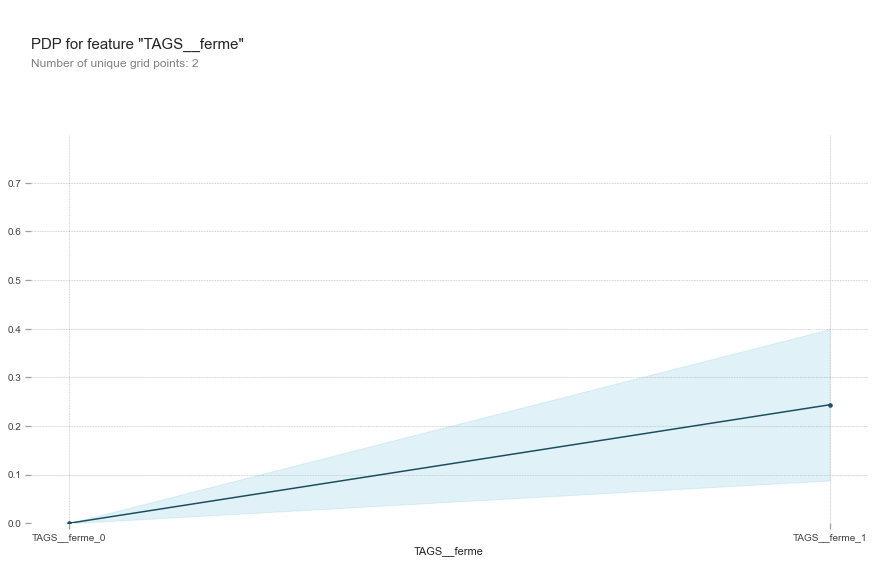

In [268]:
variable = 'TAGS__ferme' 
pdp_curve(variable)

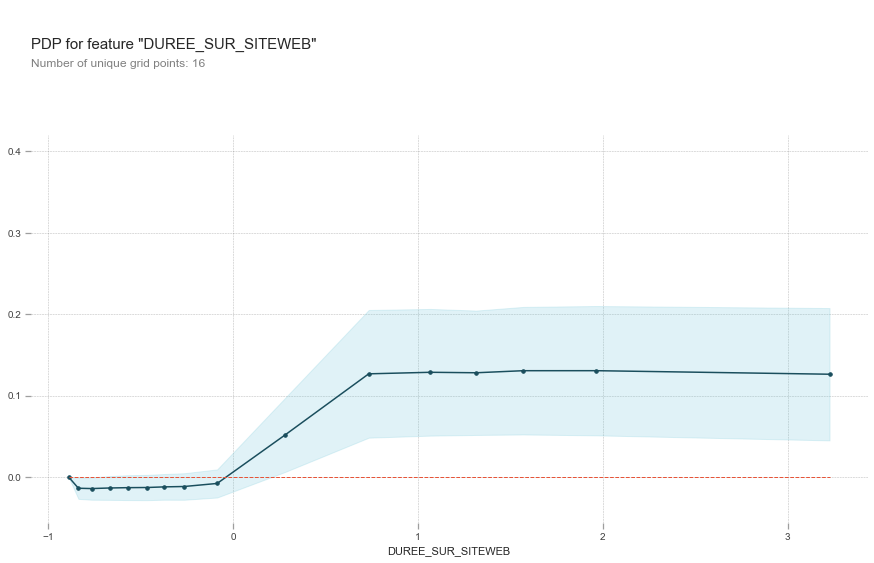

In [269]:
variable = 'DUREE_SUR_SITEWEB' 
pdp_curve(variable)

## Individual Conditional Expectation Curves (ICE curves) <a name="part2.d"></a>

In [270]:
X_ref = X_test.copy().sample(100, random_state=42)

In [271]:
def ICE_curve(variable) :

    ice_df = ice(X_ref, variable, f_predict, num_grid_points=20)

    fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

    ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
             alpha=0.1, plot_pdp=True, ax=ax_ice)

    ax_ice.set_xlabel(variable)
    ax_ice.set_ylabel('Prediction') 
    ax_ice.set_title('ICE Curves')

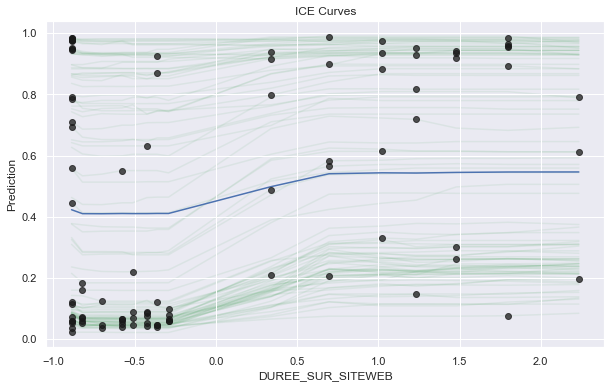

In [272]:
variable = 'DUREE_SUR_SITEWEB'
ICE_curve(variable)

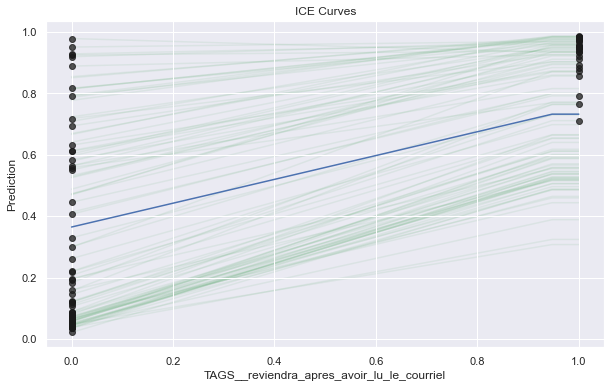

In [273]:
variable = 'TAGS__reviendra_apres_avoir_lu_le_courriel' 
ICE_curve(variable)

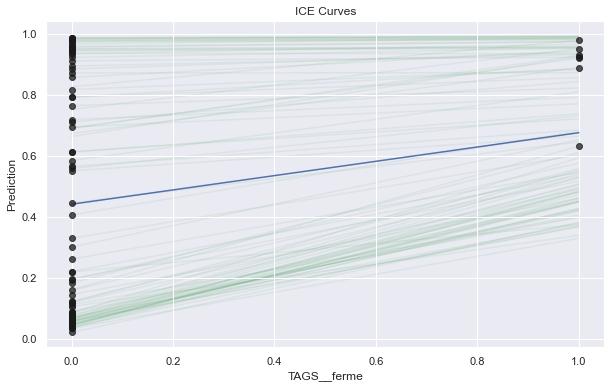

In [274]:
variable = 'TAGS__ferme'
ICE_curve(variable)

# 3. Décomposition en contributions <a name="part3"></a>

## Tree Interpreter <a name="part3.b"></a>

In [275]:
%%time
predictions, bias, contributions = ti.predict(model, X_test)

CPU times: user 1.04 s, sys: 155 ms, total: 1.19 s
Wall time: 1.19 s


In [276]:
model.estimators_[0].tree_.value

array([[[0.62197444, 0.37802556]],

       [[0.78289474, 0.21710526]],

       [[0.80028354, 0.19971646]],

       [[0.74641676, 0.25358324]],

       [[0.81915606, 0.18084394]],

       [[0.87746171, 0.12253829]],

       [[0.94107452, 0.05892548]],

       [[0.94318182, 0.05681818]],

       [[0.95221239, 0.04778761]],

       [[0.95676692, 0.04323308]],

       [[0.95372233, 0.04627767]],

       [[1.        , 0.        ]],

       [[0.87878788, 0.12121212]],

       [[0.85185185, 0.14814815]],

       [[1.        , 0.        ]],

       [[0.21428571, 0.78571429]],

       [[1.        , 0.        ]],

       [[0.        , 1.        ]],

       [[0.7       , 0.3       ]],

       [[0.25      , 0.75      ]],

       [[0.5       , 0.5       ]],

       [[0.        , 1.        ]],

       [[1.        , 0.        ]],

       [[0.        , 1.        ]],

       [[1.        , 0.        ]],

       [[0.53917051, 0.46082949]],

       [[0.55555556, 0.44444444]],

       [[0.51336898, 0.48663

In [208]:
#expected_value = None
expected_bias = bias
expected_predictions = y_test

np.testing.assert_almost_equal(bias, expected_bias)

for class_index in (0, 1):
    np.testing.assert_almost_equal(contributions[:, :, class_index].sum(axis=1) + bias[:, class_index],
                                   expected_predictions[:, class_index])
    np.testing.assert_almost_equal(predictions[:, class_index],
                                   expected_predictions[:, class_index])

ValueError: key of type tuple not found and not a MultiIndex

# SHappley Additive exPlaination (SHAP) <a name="part3.c"></a>

In [277]:
shap.initjs()

In [278]:
%%time
explanation = shap.TreeExplainer(model)
shap_values = explanation.shap_values(X_test)[1]
df_contrib = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
bias = explanation.expected_value[1]

CPU times: user 17.2 s, sys: 43.8 ms, total: 17.3 s
Wall time: 17.3 s


In [279]:
index = 9 # choose an integer
shap.force_plot(explanation.expected_value[1], shap_values[index, :], X_test.iloc[index, :])

In [212]:
shap.force_plot(explanation.expected_value[1], shap_values, X_test)

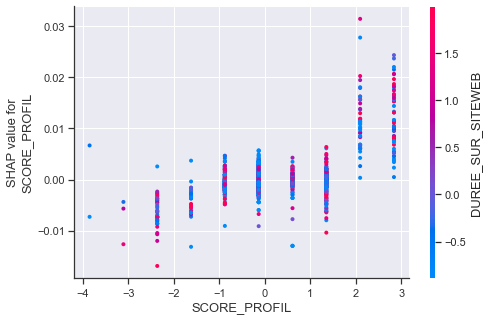

In [280]:
variable_1 = "SCORE_PROFIL"
variable_2 = "DUREE_SUR_SITEWEB"
interaction_index = X_test.columns.tolist().index(variable_2)

shap.dependence_plot(variable_1, shap_values, X_test, interaction_index=interaction_index)

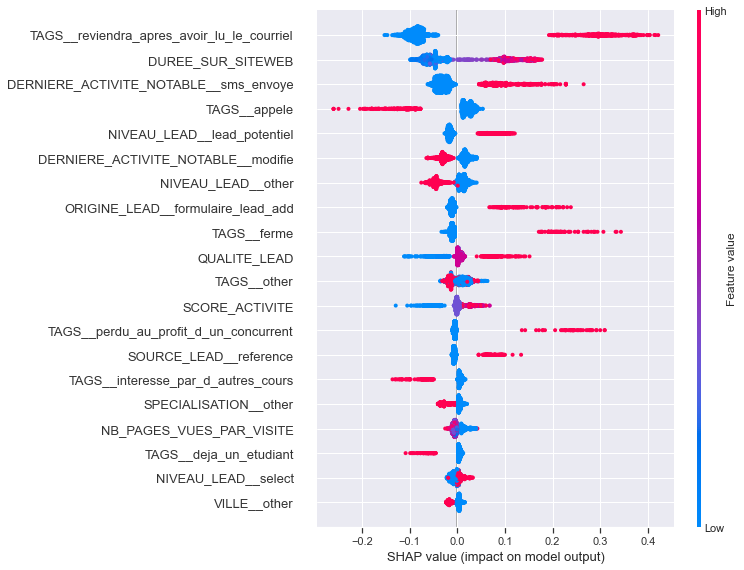

In [281]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

### Plots personnalisés, avec ré-agrégation des variables dummifiées <a name="part3.c.2"></a>

In [282]:
interpretable_dict = prepare_interpretable_contribution(X_test, f_predict, df_contrib, bias)

In [283]:
offline.init_notebook_mode(connected=True)

In [284]:
def explain_customer(index) :
    num_features_plot = 5
    is_horizontal = True

    fig = plot_observation_contribution(interpretable_dict=interpretable_dict,
                                        index_ref=index,
                                        num_features_plot=num_features_plot,
                                        is_horizontal=is_horizontal)
    offline.iplot(fig)

In [285]:
index = 9 # You can change this parameter to change the customer.
explain_customer(index)

/Users/alexei/lead-scoring-alessio-marieme/.venv/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:405: DeprecationWarning:

plotly.graph_objs.Margin is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Margin




In [286]:
interpretable_dict['agg_X_ref'].columns.tolist()

['ORIGINE_LEAD',
 'SOURCE_LEAD',
 'NIVEAU_LEAD',
 'TAGS',
 'VILLE',
 'SPECIALISATION',
 'DERNIERE_ACTIVITE_NOTABLE',
 'NB_VISITES',
 'SCORE_ACTIVITE',
 'NB_PAGES_VUES_PAR_VISITE',
 'SCORE_PROFIL',
 'DUREE_SUR_SITEWEB',
 'INDEX_ACTIVITE',
 'QUALITE_LEAD']

In [287]:
def plot_contribution(variable) :
    sample_size = 3000 # Numbers of points to plot

    fig = plot_single_feature(interpretable_dict, variable=variable, max_sample_size=sample_size)  
    offline.iplot(fig)

In [288]:
variable = "ORIGINE_LEAD"
plot_contribution(variable)

In [582]:
%%time
n_clusters = 10 # The Kernel is computed using the training set. 

explanation = shap.KernelExplainer(f_predict, shap.kmeans(X_train, n_clusters))
shap_values = explanation.shap_values(X_test)
df_contrib = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
bias = explanation.expected_value


CPU times: user 24min 39s, sys: 2min 58s, total: 27min 38s
Wall time: 13min 9s


In [586]:
shap.force_plot(
    explanation.expected_value, 
    shap_values[index, :], 
    X_test.iloc[index, :])

# Interpretable Models _per se_ <a name="part4"></a>

### 1. Entraînement de Skope Rules <a name="part4.b.1"></a>

In [289]:
skope_rules_clf = SkopeRules(feature_names=X_train.columns, random_state=42, n_estimators=50,
                             recall_min=0.05, precision_min=0.9, max_samples=0.5,
                             max_depth_duplication=2, max_depth=3)
skope_rules_clf.fit(X_train, y_train)

SkopeRules(feature_names=Index(['ORIGINE_LEAD__api', 'ORIGINE_LEAD__formulaire_lead_add',
       'ORIGINE_LEAD__other', 'ORIGINE_LEAD__soumission_landing_page',
       'SOURCE_LEAD__direct_traffic', 'SOURCE_LEAD__facebook',
       'SOURCE_LEAD__google', 'SOURCE_LEAD__olark_chat',
       'SOURCE_LEAD__organic_search', 'SOURCE_LEAD__other',
       'SOURCE_LEAD__reference', 'SOURCE_LEAD__referral...
       'DERNIERE_ACTIVITE_NOTABLE__other',
       'DERNIERE_ACTIVITE_NOTABLE__page_visitee_sur_le_site',
       'DERNIERE_ACTIVITE_NOTABLE__sms_envoye', 'NB_VISITES', 'SCORE_ACTIVITE',
       'NB_PAGES_VUES_PAR_VISITE', 'SCORE_PROFIL', 'DUREE_SUR_SITEWEB',
       'INDEX_ACTIVITE', 'QUALITE_LEAD'],
      dtype='object'),
           max_depth_duplication=2, max_samples=0.5, n_estimators=50,
           precision_min=0.9, random_state=42, recall_min=0.05)

In [290]:
skope_rules_scoring = skope_rules_clf.score_top_rules(X_test)
random_forest_scoring = f_predict(X_test)

### 2. Extraction des règles de Skope Rules <a name="part4.b.2"></a>

In [291]:
n_rules = len(skope_rules_clf.rules_)
print(f'{n_rules} rules have been built with SkopeRules.')

4 rules have been built with SkopeRules.


In [292]:
def compute_y_pred_from_query(X, rule):
    '''Given a query (some rule using greater or lesser sign), return the predictions

    Parameters
    ----------
    X : pd.DataFrame
        dataframe on which query must be called
    rule : str
        query/rule used to compute the predictions

    Returns
    -------
    score : np.ndarray
        predictions in same order than X index

    '''
    score = np.zeros(X.shape[0])
    X = X.reset_index(drop=True)
    score[X.query(rule).index.tolist()] = 1
    return score

def compute_performances_from_y_pred(y_true, y_pred, index_name='default_index'):
    '''Compute precision/recall performances given predictions and ground truth

    Parameters
    ----------
    y_true : pd.Series/np.ndarray
        ground truth from binary classification
    y_pred : pd.Series/np.ndarray
        predictions from binary classification
    index_name.: str
        index used for results dataframe, default is 'default_index'

    Returns
    -------
    df : pd.DataFrame
        dataframe with precision and recall of predictions

    '''
    df = pd.DataFrame(data=
        {
            'precision':[sum(y_true * y_pred)/sum(y_pred)],
            'recall':[sum(y_true * y_pred)/sum(y_true)]
        },
        index=[index_name],
        columns=['precision', 'recall']
    )
    return df

def compute_train_test_query_performances(X_train, y_train, X_test, y_test, rule):
    '''Compute precision/recall on both train and test given a rule

    Parameters
    ----------
    X_train : pd.DataFrame
        training dataset
    y_train : pd.Series/np.ndarray
        ground truth on training dataset (same order than X_train)
    X_test : pd.DataFrame
        testing dataset
    y_test : pd.Series/np.ndarray
        ground truth on testing dataset (same order than X_test)
    rule : str
        query/rule used to compute the predictions

    Returns
    -------
    performances : pd.DataFrame
        dataframe with precision and recall for both training and
        testing predictions using the rule

    '''
    y_train_pred = compute_y_pred_from_query(X_train, rule)
    y_test_pred = compute_y_pred_from_query(X_test, rule)
    
    performances = None
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_train, y_train_pred, 'train_set')],
        axis=0)
    performances = pd.concat([
        performances,
        compute_performances_from_y_pred(y_test, y_test_pred, 'test_set')],
        axis=0)
            
    return performances

In [293]:
for i in range(n_rules):
    print(f'Rule {i + 1}:')
    display(compute_train_test_query_performances(X_train, y_train,
                                                  X_test, y_test,
                                                  skope_rules_clf.rules_[i][0]))

Rule 1:


precision    recall
train_set   0.968499  0.563218
test_set    0.972477  0.558630

Rule 2:


precision    recall
train_set   0.983965  0.484914
test_set    0.991643  0.469038

Rule 3:


precision    recall
train_set   0.996516  0.102730
test_set    0.985294  0.088274

Rule 4:


precision    recall
train_set   0.905983  0.076149
test_set    0.918919  0.089592

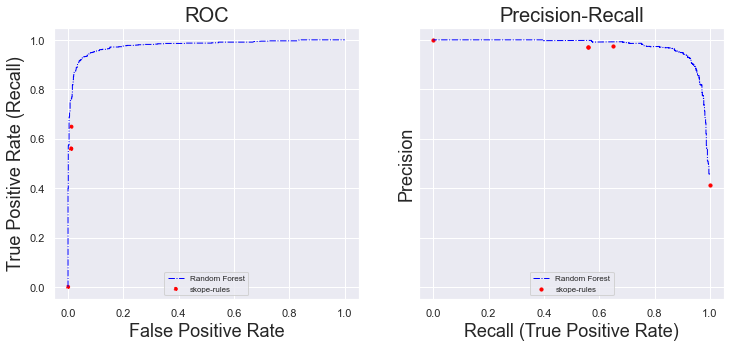

In [294]:
plot_scores(y_test, scores_with_line=[random_forest_scoring], scores_with_points=[skope_rules_scoring])

In [295]:
n_rule_chosen = 3
y_pred = skope_rules_clf.predict_top_rules(X_test, n_rule_chosen)

print(f'The performances reached with {n_rule_chosen} discovered rules are the following:')
compute_performances_from_y_pred(y_test, y_pred, 'test_set')

The performances reached with 3 discovered rules are the following:


precision    recall
test_set   0.974257  0.648221